# Dimensionality reduction 1

__Week 2 - 3 May 2023__

Practice applying and using dimensionality rediuction for analysing datasets with Principal Component Analysis (`PCA` & `Kernel PCA`).

---
### Data

The dataset is a photometric catalogue of galaxies. These galaxies were found in the 2-square degree field on the sky called COSMOS by space- and ground-based telescopes.

The radiation flux (energy per second) of each galaxy is measured in 8 bands (i.e. wavelengths of light) that span the spectrum from <span style="color:blue;">blue</span> to <span style="color:rgb(192,4,1,1);">infrared</span>: `u, r, z++, yHSC, H, Ks, SPLASH1, SPLASH2`. The fluxes are not corrected for any effects, such as distance to a galaxy, therefore there is a systematic effect in their measurements (called redshift).

So, in addition to its photometry each galaxy has its observed bias and physical properties:
* `redshift`$^1$ - systematic bias in flux measurements.
* `log_mass` - stellar mass in units of $log_{10}$ (inferred from a combination of fluxes and redshifts).
* `log_sfr` - rate of star formation in units of $log_{10}$ (inferred from a combination of fluxes and redshifts).
* `is_star_forming` - classification, based on galaxy colours (inferred from a combinations of fluxes and redshifts).

<span style="font-size:0.9em;"> $^1$ - redshift is the reddening of light that is proportianal to the velocity of an object receding away. On the sky, object velocities are proportional to their distances from us ([find out more](https://www.anisotropela.dk/encyclo/redshift.html)). </span>

---
### Exercise

Analyze the galaxy catalogue applying dimensionality reduction to galaxy fluxes.

* Apply `PCA` to fluxes. Can you find a base of principal compoenents that separates galaxies into star forming and dead? Does PCA give you a way to differentiate between various properties of galaxies?
* Think about preprocessing the data, if you haven't yet, and see if you can find a more representative set of principal components.
* Apply `Kernel PCA` afterwards. Does this give you a more meaningful vector space? If so, why?
* Apply `t-SNE`. Does it give you a cleaner separation between objects with different properties?
* Apply `UMAP`, for comparison.

---
* Authors:  Vadim Rusakov, Charles Steinhardt
* Email:  vadim.rusakov@nbi.ku.dk
* Date:   27th of April 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

2023-05-03 11:34:25.493233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load in the data:

In [2]:
file = "datasets/cosmos2015.csv"
df = pd.read_csv(file, index_col=False)
df

,redshift,log_sfr,log_mass,is_star_forming,u_flux,r_flux,zpp_flux,yhsc_flux,h_flux,ks_flux,splash1_flux,splash2_flux
0,0.173,-0.185166,10.08220,0,9.079690,107.628000,249.30300,280.15900,426.95200,474.21400,441.68500,343.36600
1,0.116,-0.470215,9.02189,0,8.570400,52.884300,105.81000,117.26600,156.32100,146.49400,167.30100,115.66600
2,0.232,0.228303,10.24250,0,6.588400,89.080900,215.42300,247.41400,387.10000,455.83800,437.71700,362.45100
3,0.208,-1.797320,7.98980,1,0.241170,0.975295,1.47919,1.49645,2.84649,3.43519,6.33809,7.14621
4,0.489,-0.430443,10.65050,0,0.382350,10.460500,34.27770,39.15310,70.91750,87.37050,74.89360,57.32130
...,...,...,...,...,...,...,...,...,...,...,...,...
20350,0.711,1.044900,10.11260,1,2.480290,6.360220,15.51100,17.26700,27.15210,33.56980,41.62840,30.65300
20351,0.361,0.641278,9.75474,0,1.962290,18.296000,46.32240,52.10730,91.22180,116.03600,80.30160,79.08950
20352,0.489,0.104801,10.76330,0,0.641645,13.892800,46.05850,52.97450,101.43100,129.24300,116.25500,93.80680
20353,0.460,-1.237760,10.65170,0,0.779877,16.147200,40.55250,45.68750,74.65830,93.49390,59.48300,47.03440


Select a random sub-sample of the dataset. `PCA` does computations linearly, therefore it's quick and you can choose the whole dataset if you wish.

In [3]:
# select a random sub-sample of the dataset
n = 1000
idxs = np.arange(df.shape[0])
idxs_rand = np.random.choice(idxs, size=n)
df_cut = df.iloc[idxs_rand] # dataframe
X = df.iloc[idxs_rand].values # array

flux_cols = list(df.columns[4:]) # flux column names
flux_idxs = np.argwhere(np.isin(df.columns, flux_cols)).flatten() # flux column indices

## Principal Component Analysis (PCA)

Now take the galaxy data (fluxes) and find out whether you can reduce it to a couple of meaningful principal components using `PCA`. By meaningful, we are interested in the method that is capable of separating galaxies into `star forming` or `dead`.

Use the following parameters: `n_components=2`. The user interface of the PCA in sklearn is the same as for all other similar classes (see PCA [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)).

You can access training data (only fluxes columns) as `X[:, flux_idxs]`.

In [4]:
pca = PCA() # get a pca object of class PCA()
y_pcs = pca.fit_transform(X[:, flux_idxs]) # train pca object on fluxes (raw observed data)

y_pcs.shape

(1000, 8)

/tmp/ipykernel_7235/1823626224.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(y_pcs[is_sf, 0], y_pcs[is_sf, 1], s=0.02, c='b', norm=LogNorm())
/tmp/ipykernel_7235/1823626224.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(y_pcs[~is_sf, 0], y_pcs[~is_sf, 1], s=0.02, c='r', norm=LogNorm())


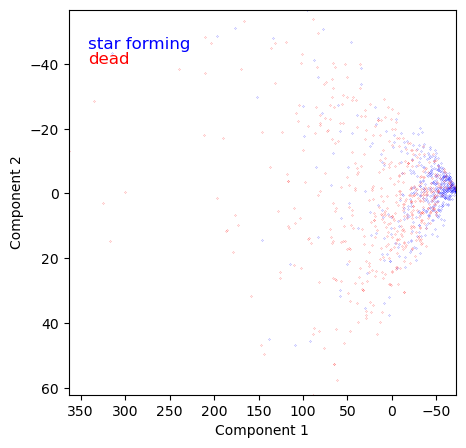

In [5]:
# create a figure
fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
is_sf = np.isin(df_cut.loc[:, 'is_star_forming'], 1) # is a galaxy forming stars, i.e. alive?

# scatter plot using two principal components stored in y_pcs
ax.scatter(y_pcs[is_sf, 0], y_pcs[is_sf, 1], s=0.02, c='b', norm=LogNorm())
ax.scatter(y_pcs[~is_sf, 0], y_pcs[~is_sf, 1], s=0.02, c='r', norm=LogNorm())
ax.annotate("star forming", xy=(0.05, 0.9), xycoords="axes fraction", 
            color='b', fontsize=12)
ax.annotate("dead", xy=(0.05, 0.86), xycoords="axes fraction", 
            color='r', fontsize=12)
plt.show()

* Make scatter plots coloured by different galaxy properties: `log_mass`, `log_sfr`, `redshift`. Is the low-dimensional representation meaningful in any one of the properties? Can you argue why?

Below is an example code for colouring the scatter by some property, eg., `log_mass`:

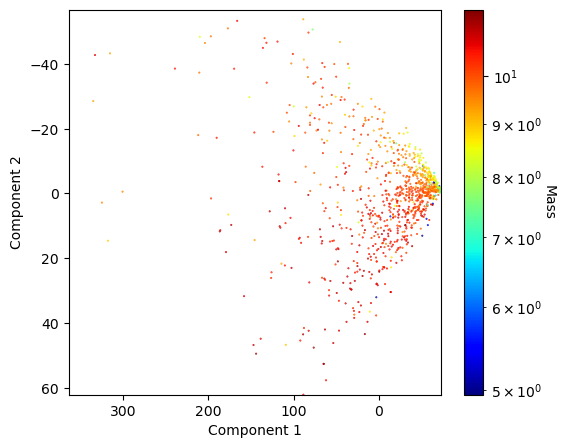

In [6]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y_pcs[:,0], y_pcs[:,1], s=0.2, 
                c=df_cut.loc[:, 'log_mass'], cmap='jet', norm=LogNorm())
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Mass', rotation=270, labelpad=10)
plt.show()

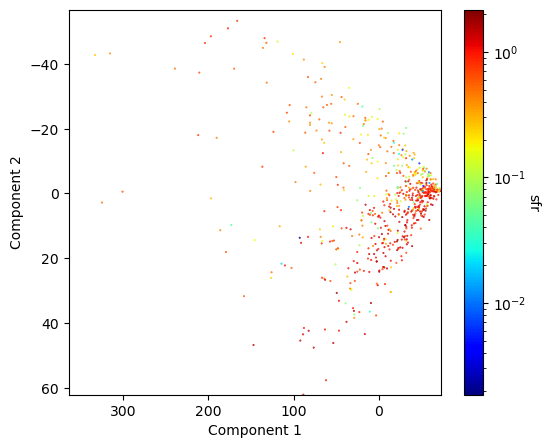

In [7]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y_pcs[:,0], y_pcs[:,1], s=0.2, 
                c=df_cut.loc[:, 'log_sfr'], cmap='jet', norm=LogNorm())
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('sfr', rotation=270, labelpad=10)
plt.show()

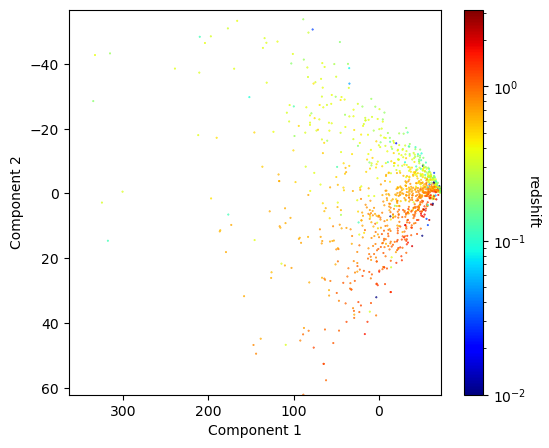

In [8]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y_pcs[:,0], y_pcs[:,1], s=0.2, 
                c=df_cut.loc[:, 'redshift'], cmap='jet', norm=LogNorm())
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('redshift', rotation=270, labelpad=10)
plt.show()

## Kernel PCA

For now, let us continue throwing these data at other algorithms to get some practice with them. `KernelPCA` is a variant of the PCA, which can use a range of kernels for non-linear operations. I.e., this extension gives flexibility in separating the data that are not linearly-separable.

Use the following parameters: `n_components=2`, `kernel='cosine'`. Make sure to try different kernels for reducing the dimensionality. See documentation for `KernelPCA` in **sklearn**.

For Kernel PCA see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA).

In [9]:
kpca = KernelPCA(n_components=2, kernel="cosine")
y_pcs = kpca.fit_transform(X[:, flux_idxs])

/tmp/ipykernel_7235/892342967.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(y_pcs[is_sf, 0], y_pcs[is_sf, 1], s=0.02, c='b', norm=LogNorm())
/tmp/ipykernel_7235/892342967.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(y_pcs[~is_sf, 0], y_pcs[~is_sf, 1], s=0.02, c='r', norm=LogNorm())


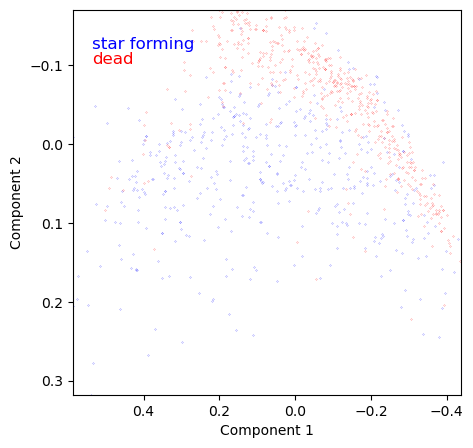

In [10]:
fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
is_sf = np.isin(df_cut.loc[:, 'is_star_forming'], 1) # is a galaxy forming stars, i.e. alive?

ax.scatter(y_pcs[is_sf, 0], y_pcs[is_sf, 1], s=0.02, c='b', norm=LogNorm())
ax.scatter(y_pcs[~is_sf, 0], y_pcs[~is_sf, 1], s=0.02, c='r', norm=LogNorm())
ax.annotate("star forming", xy=(0.05, 0.9), xycoords="axes fraction", 
            color='b', fontsize=12)
ax.annotate("dead", xy=(0.05, 0.86), xycoords="axes fraction", 
            color='r', fontsize=12)
plt.show()

* Again, make scatter plots coloured by different galaxy properties: `log_mass`, `log_sfr`, `redshift`. Is the low-dimensional representation more meaningful with this algorithm? Can you argue why?

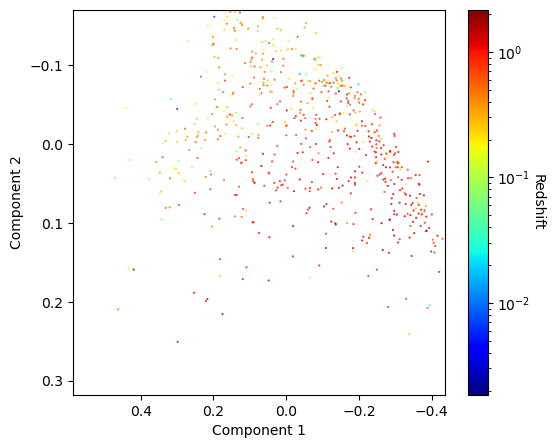

In [11]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y_pcs[:,0], y_pcs[:,1], s=0.2, norm=LogNorm(),
                c=df_cut.loc[:, 'log_sfr'], cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Redshift', rotation=270, labelpad=10)
plt.show()

### t-SNE

Now, try to run `t-SNE` on the dataset (for examples or set-up see documentation for `t-SNE` on sklearn [website](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)). Use `perplexity=50, method='barnes_hut', n_iter=1000, random_state=42, verbose=2` for now. In the next class we will put more emphasis on the importance of the optimal values for theses parameters.

* How well does `t-SNE` help to differentiate between two classes here?

* Do you get clusters of galaxies or a continuum?

* Which physical property is the most distinctly separated in the reduced space (again, use colouring of scatter to analyze this)?

In [12]:
# running t-SNE
tsne = TSNE(perplexity=50, method='barnes_hut', n_iter = 1000, random_state = 42, verbose=2)
y = tsne.fit_transform(X[:, flux_idxs])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.445523
[t-SNE] Computed conditional probabilities in 0.047s
[t-SNE] Iteration 50: error = 55.0400810, gradient norm = 0.0247692 (50 iterations in 0.174s)
[t-SNE] Iteration 100: error = 53.2592468, gradient norm = 0.0026708 (50 iterations in 0.137s)
[t-SNE] Iteration 150: error = 53.1036491, gradient norm = 0.0003483 (50 iterations in 0.147s)
[t-SNE] Iteration 200: error = 53.0792198, gradient norm = 0.0003493 (50 iterations in 0.124s)
[t-SNE] Iteration 250: error = 53.0708084, gradient norm = 0.0002474 (50 iterations in 0.193s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.070808
[t-SNE] Iteration 300: error = 0.5816356, gradient norm = 0.0147830 (50 iterations in 0.213s)
[t-SNE] Iteration 350: error = 0.4360814, gradient norm = 0.0101

/tmp/ipykernel_7235/993925881.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(y[is_sf, 0], y[is_sf, 1], s=0.05, c='b', norm=LogNorm())
/tmp/ipykernel_7235/993925881.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(y[~is_sf, 0], y[~is_sf, 1], s=0.05, c='r', norm=LogNorm())


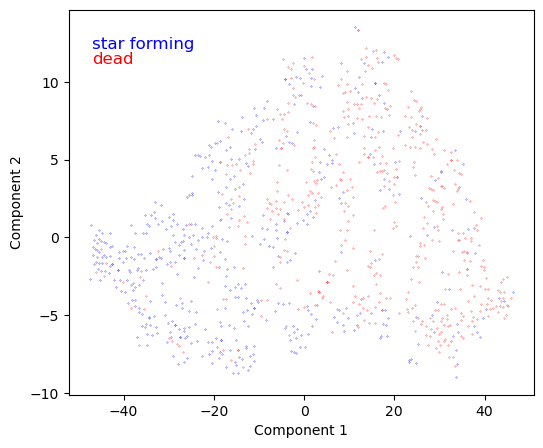

In [13]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
is_sf = np.isin(df_cut.loc[:, 'is_star_forming'], 1)

ax.scatter(y[is_sf, 0], y[is_sf, 1], s=0.05, c='b', norm=LogNorm())
ax.scatter(y[~is_sf, 0], y[~is_sf, 1], s=0.05, c='r', norm=LogNorm())
ax.annotate("star forming", xy=(0.05, 0.9), xycoords="axes fraction", 
            color='b', fontsize=12)
ax.annotate("dead", xy=(0.05, 0.86), xycoords="axes fraction", 
            color='r', fontsize=12)
plt.show()

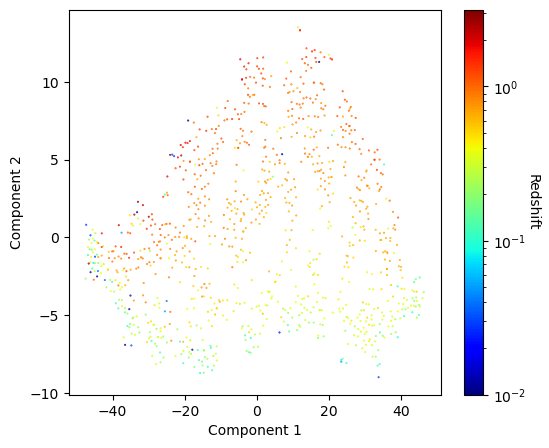

In [14]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y[:,0], y[:,1], s=0.2, norm=LogNorm(),
                c=df_cut.loc[:, 'redshift'], cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Redshift', rotation=270, labelpad=10)
plt.show()

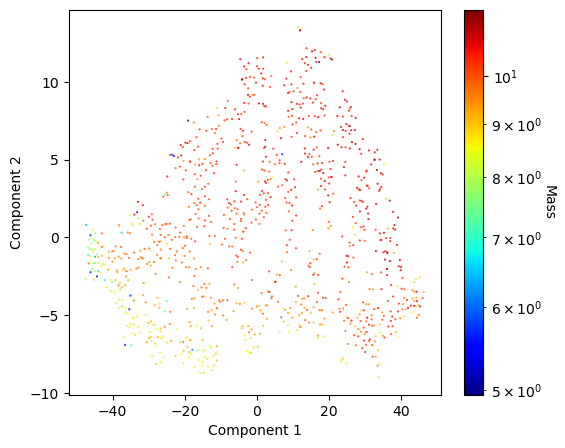

In [15]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y[:,0], y[:,1], s=0.2, norm=LogNorm(),
                c=df_cut.loc[:, 'log_mass'], cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Mass', rotation=270, labelpad=10)
plt.show()

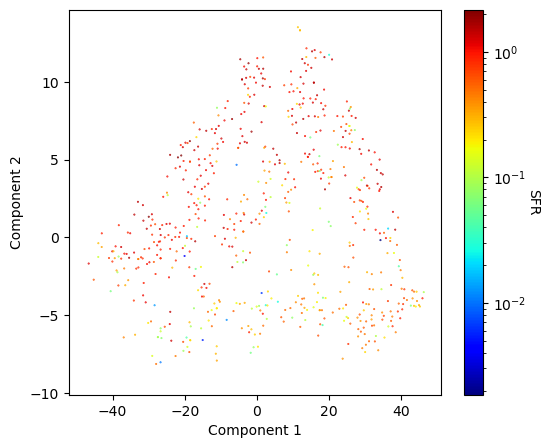

In [16]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y[:,0], y[:,1], s=0.2, norm=LogNorm(),
                c=df_cut.loc[:, 'log_sfr'], cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('SFR', rotation=270, labelpad=10)
plt.show()

### UMAP

Now try using `UMAP`. For documentation see the UMAP [webpage](https://umap-learn.readthedocs.io/en/latest/api.html). This has the same interface as the other embedding classes above. Use with `n_components=2, n_neighbors=50, random_state=42`. 

* Do you get something similar to `t-SNE`?

* How well can you map different properties in the reduced space?

* Do you get clusters or continuous distributions? Which physical property is the most strongly separable with `UMAP`?

In [17]:
map = umap.UMAP(n_components=2, n_neighbors=50, random_state=42)
y = map.fit_transform(X[:, flux_idxs])

/tmp/ipykernel_7235/156028749.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(y[is_sf, 0], y[is_sf, 1], s=0.02, c='b', norm=LogNorm())
/tmp/ipykernel_7235/156028749.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(y[~is_sf, 0], y[~is_sf, 1], s=0.02, c='r', norm=LogNorm())


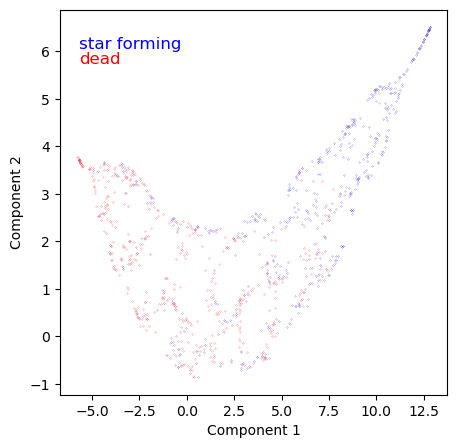

In [18]:
fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
is_sf = np.isin(df_cut.loc[:, 'is_star_forming'], 1)

ax.scatter(y[is_sf, 0], y[is_sf, 1], s=0.02, c='b', norm=LogNorm())
ax.scatter(y[~is_sf, 0], y[~is_sf, 1], s=0.02, c='r', norm=LogNorm())
ax.annotate("star forming", xy=(0.05, 0.9), xycoords="axes fraction", 
            color='b', fontsize=12)
ax.annotate("dead", xy=(0.05, 0.86), xycoords="axes fraction", 
            color='r', fontsize=12)
plt.show()

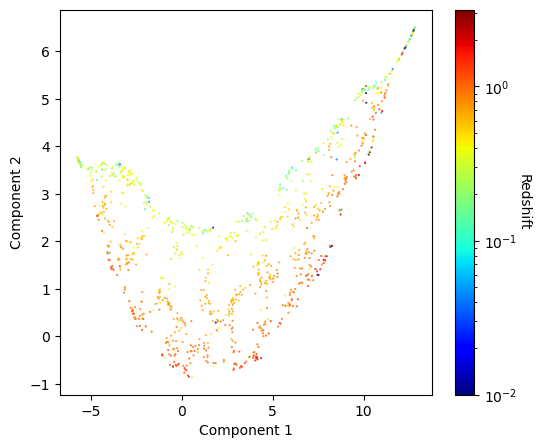

In [19]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y[:,0], y[:,1], s=0.2, norm=LogNorm(),
                c=df_cut.loc[:, 'redshift'], cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Redshift', rotation=270, labelpad=10)
plt.show()

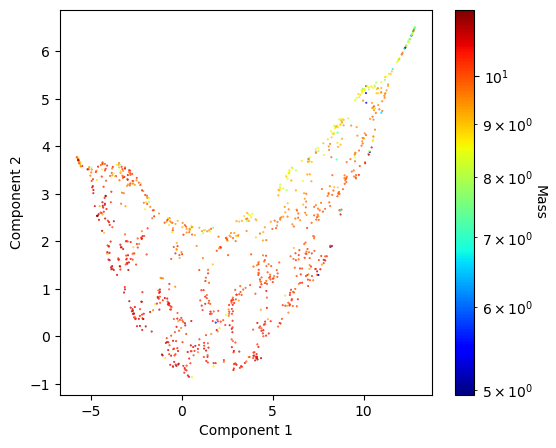

In [20]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y[:,0], y[:,1], s=0.2, norm=LogNorm(),
                c=df_cut.loc[:, 'log_mass'], cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Mass', rotation=270, labelpad=10)
plt.show()

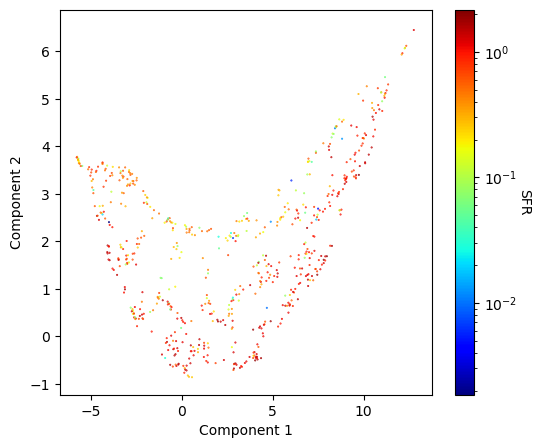

In [21]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y[:,0], y[:,1], s=0.2, norm=LogNorm(),
                c=df_cut.loc[:, 'log_sfr'], cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('SFR', rotation=270, labelpad=10)
plt.show()

# Problems

## Learning points:

tSNE and UMAP are more powerful than PCA, because they are non-linear.
If you believe there are linear relations in the data, use PCA (which is fast and which you can inspect right after), possibly followed by UMAP or tSNE.
